<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-05/AEs_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


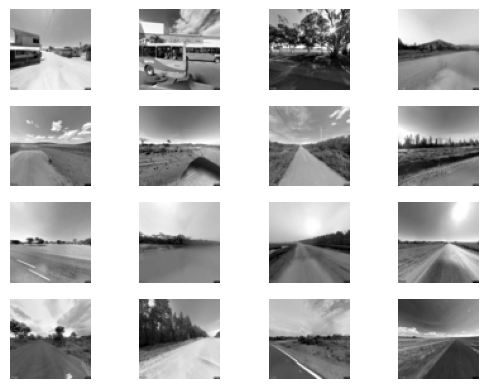

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from google.colab import drive
import torch

drive.mount('/content/drive')

im_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)),torchvision.transforms.ToTensor(), torchvision.transforms.Grayscale()])

train_im = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Street_View_Images', transform = im_transform)
train_loader = torch.utils.data.DataLoader(train_im, batch_size = 32, shuffle = True)
for i, (x, _) in enumerate(train_loader):
  if i == 16: break
  plt.subplot(4, 4, i+1)
  x = x.permute((0,2,3,1))
  plt.imshow(x[0, :, :, :], cmap = 'gray')
  plt.axis('off')

In [312]:
import torch.nn as nn

class CVAE(nn.Module):
  def __init__(self, latent_dim, input_dim = (28, 28)):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = (3,3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size = (3,3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * (input_dim[0] * input_dim[1])//16, latent_dim*2)
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 16*16*32),
        nn.ReLU(),
        nn.Unflatten(1, (32, 16, 16)),
        nn.ConvTranspose2d(32, 64, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1, bias = False),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1, bias = False),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size = (3,3), stride = 1, padding = 1, bias = False)

    )


  def sample(self, eps = None):
    if eps is None:
      eps = torch.randn([100, self.latent_dim])
    return self.decode(eps, apply_sigmoid = True)

  def encode(self, x):
    # print(torch.split(x, 2, dim=1))
    mean, logvar = torch.split(self.encoder(x), 2, dim=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = torch.randn(mean.shape)
    return eps * torch.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid = False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = torch.sigmoid(logits)
      return probs
    return logits

In [325]:
from re import X
from torch import optim

bce_loss = nn.BCEWithLogitsLoss()

def log_norm_pdf(sample, mean, logvar, raxis = 1):
  if type(logvar) is float:
    return torch.sum(-0.5*((sample-mean)**2*np.exp(-logvar)+logvar+np.log(2*np.pi)), dim=raxis)
  else:
    return torch.sum(-0.5*((sample-mean)**2*torch.exp(-logvar)+logvar+np.log(2*np.pi)), dim=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  xlogit = model.decode(z)
  logpx_z = -bce_loss(xlogit, x)
  logpz = log_norm_pdf(z, 0., 0.)
  logqz_x = log_norm_pdf(z, mean, logvar)
  return -torch.mean(logpx_z + logpz - logqz_x)

model = CVAE(2, (64, 64))
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
epochs = 10

for e in range(epochs):
  model.train()
  for i, (train_im, _) in enumerate(train_loader):
    optimizer.zero_grad()
    loss = compute_loss(model, train_im)
    print(loss)
    loss.backward()
    optimizer.step()

torch.Size([32, 1, 64, 64])
tensor(0.7474, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.7029, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.7237, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.7309, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6764, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6982, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6858, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.7227, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.7025, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6763, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.7214, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6920, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6864, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6964, grad_fn=<NegBackward0>)
torch.Size([32, 1, 64, 64])
tensor(0.6714, grad_fn=<NegBackwar

KeyboardInterrupt: 

In [263]:
class ShapePrint(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    print(x.shape)
    return x


class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(100, 64*16*16, bias=False),
        nn.Unflatten(1, (64, 16, 16)),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size = (5,5), stride = 1, padding = 2, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size = (5,5), stride = 2, padding = 2, output_padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 1, kernel_size = (5,5), stride = 2, padding = 2, output_padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.layers(x)

class Discriminator(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size = (3, 3), stride = 1, padding = 1),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(16, 32, kernel_size = (3, 3), stride = 1, padding = 1),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Flatten(),
        nn.Linear(input_size*input_size*32, 1)
    )

  def forward(self, x):
    return self.layers(x)



(1, 1, 64, 64)
tensor([[0.0251]], grad_fn=<AddmmBackward0>)


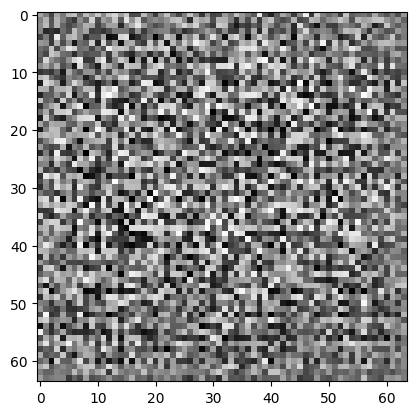

In [264]:
import torch

generator = Generator()

noise = torch.randn([1, 100])
# noise = noise.unsqueeze(0).unsqueeze(0)
generated_image = generator(noise)
gen_im = torch.Tensor.detach(generated_image).numpy()
print(gen_im.shape)
plt.imshow(gen_im[0, 0, :, :], cmap='gray')

discriminator = Discriminator(gen_im.shape[2])

print(discriminator(generated_image))

In [327]:
from torch import optim

bce_loss = nn.BCEWithLogitsLoss()

def gen_loss(output):
  return bce_loss(output, torch.ones_like(output))

def disc_loss(real, fake):
  real_loss = bce_loss(real, torch.ones_like(real))
  fake_loss = bce_loss(fake, torch.zeros_like(fake))
  return real_loss + fake_loss

gen_opt = optim.Adam(generator.parameters(), lr = 0.0001)
disc_opt = optim.Adam(discriminator.parameters(), lr = 0.0001)
BATCH_SIZE = 32
noise_dim = 100
epochs = 500
samples_to_gen = 16
discriminator = Discriminator(64)
test_noise = torch.randn([samples_to_gen, noise_dim])


for e in range(epochs):
  generator.train()
  discriminator.train()
  for i, (train_im, _) in enumerate(train_loader):
    gen_opt.zero_grad()
    disc_opt.zero_grad()

    noise = torch.randn([BATCH_SIZE, noise_dim])
    generated_images = generator(noise)

    real_output = discriminator(train_im)
    fake_output = discriminator(generated_images)


    gen_l = gen_loss(fake_output)
    disc_l = disc_loss(real_output, fake_output)

    print(gen_l.item(), disc_l.item())

    gen_l.backward(retain_graph=True)
    disc_l.backward()
    gen_opt.step()
    disc_opt.step()

  generator.eval()
  with torch.no_grad():
    predictions = generator(test_noise)
    predictions = predictions.permute(0,2,3,1)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # print(predictions[i])
        plt.imshow(np.array(predictions[i, :, :, :]*127.5+127.5, dtype=np.uint8), cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(e))
    plt.show()




0.6685535907745361 1.3972572088241577


KeyboardInterrupt: 